# Q1

In [7]:
##Import everything we need to get the code running. 
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
import math

In [8]:
##Begin defining our variables. 
time = 2 * math.pi 

#intialization values
x_0 = 0 #x_d = 4
y_0 = 0 #y_d = 0
t_0 = math.pi/2 #t_d = math.pi/2

#velocity vector: linear velocity and angular velocity
#creation of the control array
u_1, u_2 = 1, -1/2
control = np.array([u_1,u_2])

#positional variables 
x = x_0
y = y_0
t = t_0

#velocity variables
x_dot = math.cos(t) * control[0]
y_dot = math.sin(t) * control[0]
t_dot = control[1]

#creation of the state variable array
state = np.array([x, 
                  y, 
                  t, 
                  math.cos(t) * control[0],
                  math.sin(t) * control[0],
                  control[1]])


In [9]:
##Creation of the reference trajectory----------------------------------------------------------------------------
#Interval of time over which we will be calculating.
dt = time/100
ctime = 0 
current_state = state
state_stack = state[[0,1,2]]
control_stack = control

#Here we begin the creation of the array that will represent our references states.
while ctime < time:
    ctime += dt  #update the time we are operating on.
    current_state = np.array([current_state[0] + current_state[3]*dt, 
                              current_state[1] + current_state[4]*dt, 
                              current_state[2] + current_state[5]*dt, 
                              math.cos(current_state[2] + current_state[5]*dt) * control[0],
                              math.sin(current_state[2] + current_state[5]*dt) * control[0],
                              control[1]])

    state_stack = np.vstack((state_stack,current_state[[0,1,2]]))
    control_stack = np.vstack((control_stack, control))
else:
    ctime += dt
    control[0], control[1] = 0, 0
    current_state = np.array([current_state[0] + current_state[3]*dt,
                          current_state[1] + current_state[4]*dt, 
                          current_state[2] + current_state[5]*dt, 
                          math.cos(current_state[5]*dt) * control[0],
                          math.sin(current_state[5]*dt) * control[0],
                          control[1]])
    state_stack = np.vstack((state_stack, current_state[[0,1,2]]))
    control_stack = np.vstack((control_stack, control))
    
upstack = np.hstack((state_stack,control_stack))
upstack.shape #Make sure that upstack and optimal_path have the same shape.

(103, 5)

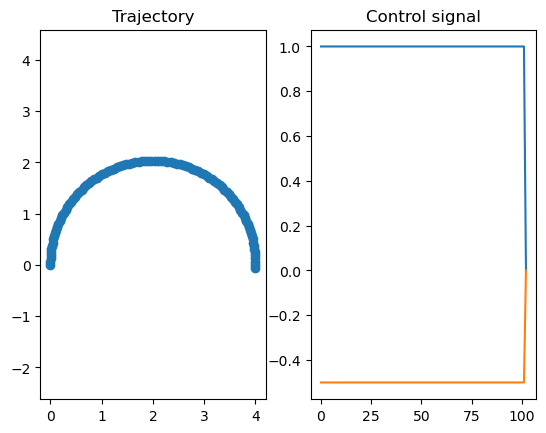

In [10]:
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(state_stack[:,0],state_stack[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(control_stack[:,0])
axs[1].set_title("Control signal")
axs[1].plot(control_stack[:,1], "tab:orange")

In [11]:
optimal_path = np.array([0,0,math.pi])

for ii in np.linspace(0,2*math.pi,102):
    optimal_path = np.vstack((optimal_path, [4/(2*math.pi)*ii, 0, math.pi/2]))

optimal_path.shape #Make sure that upstack and optimal_path have the same shape.

(103, 3)

In [12]:
## Define the objective function
# The states being optimized are being provided as [x,y,t,u1,u2,x_1,y_1,t_1,u1_1,u2_1...x_n,y_n,t_n,u1_n,u2_n]

def objective(x,y):
    #x: state vector
    #y: reference vector.
    #All objective functions in SciPy expect a numpy array
    #as their first argument which is to be optimized and must return
    #a float value.
    x = x.reshape(upstack.shape)
    x = x[:,[0,1,2]].flatten()
    #Other arguments can be provided.
    
    #Here is an implementation of the Quadratic Cost Function
    #J = ||S(t) - S_Ref(t)||^2
    return sum(abs(x - y)**2)

##Define the Constraint Functions. 
#They are defined as nonlinear constraints according to the SciPy Optimize User Guide.
#Generators are used to create arrays of constraints, one for each time step. 
def consx(x):
    return [- x[i] + x[i-5] + dt*math.cos(x[i-3])*x[i-2] for i in range(5,len(x0)-5,5)]
def consy(x):
    return [- x[i+1] + x[i-4] + dt*math.sin(x[i-3])*x[i-2] for i in range(5,len(x0)-5,5)]
def const(x):
    return [- x[i+2] + x[i-3] + dt*x[i-1] for i in range(5,len(x0)-5,5)]

xnlc = NonlinearConstraint(consx,0,0)
ynlc = NonlinearConstraint(consy,0,0)
tnlc = NonlinearConstraint(const,0,0)

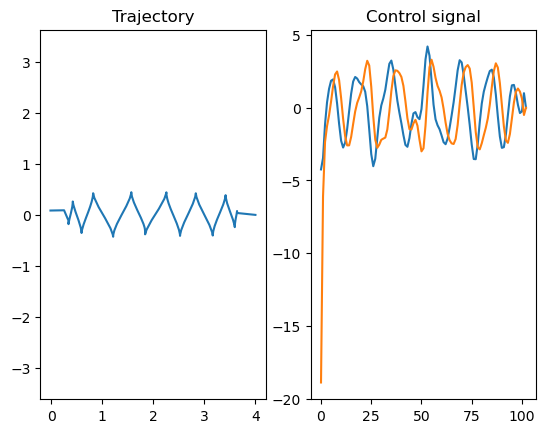

In [13]:
#Define y to be the reference path here. It is an additional argument to the objective function.
#to the optimize function
x0 = upstack.flatten()

#Change verbosity to see how the function is iterating. For a step-by-step playbook, 'verbose' = 3
res = minimize(objective, x0, args=(optimal_path.flatten()),method='trust-constr', constraints= [xnlc,ynlc,tnlc], options={'verbose':0})
sol = res.x.reshape(upstack.shape)

fig, axs = plt.subplots(1,2)
#Plotting the trajectory
axs[0].plot(sol[:,0],sol[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(sol[:,3])
axs[1].set_title("Control signal")
axs[1].plot(sol[:,4], "tab:orange")